<a href="https://www.kaggle.com/code/vanpatangan/messy-retail-data-cleaning-pipeline-eda?scriptVersionId=267730549" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries and Data

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import warnings
warnings.simplefilter("ignore")

In [2]:
customer = pd.read_csv('/kaggle/input/retail-fashion-data/customer_data.csv')
product = pd.read_csv('/kaggle/input/retail-fashion-data/product_data.csv')
sales = pd.read_csv('/kaggle/input/retail-fashion-data/sales_data.csv')
store = pd.read_csv('/kaggle/input/retail-fashion-data/store_data.csv')

# Data Summary

In [3]:
def check(df):
    """
    Generates a concise summary of DataFrame columns.
    """
    # Compute values that are constant across columns
    total_rows = len(df)
    duplicates = df.duplicated().sum()

    # Use vectorized operations 
    dtypes = df.dtypes
    instances = df.count()
    unique = df.nunique()
    sum_null = df.isnull().sum()
    #null_percentage = (df.isnull().sum() / total_rows * 100).round(2)

    # Create the summary 
    df_check = pd.DataFrame({
        'column': df.columns,
        'dtype': dtypes,
        'instances': instances,
        'unique': unique,
        'sum_null': sum_null,
        #'null_percentage': null_percentage,
        'duplicates': duplicates  
    })

    return df_check

print("Customer Data")
display(check(customer))
display(customer.head())

print("Product Data")
display(check(product))
display(product.head())

print("Sales Data")
display(check(sales))
display(sales.head())

print("Store Data")
display(check(store))
display(store.head())

Customer Data


,column,dtype,instances,unique,sum_null,duplicates
customer_id,customer_id,object,25000,25000,0,0
age,age,int64,25000,54,0,0
gender,gender,object,25000,4,0,0
city,city,object,25000,5,0,0
email,email,object,24504,24504,496,0


,customer_id,age,gender,city,email
0,C000001,61,Other,Lisbon,user1@example.com
1,C000002,61,Female,Coimbra,user2@example.com
2,C000003,22,Female,Faro,user3@example.com
3,C000004,46,Other,Lisbon,NaN
4,C000005,47,Other,Faro,user5@example.com


Product Data


,column,dtype,instances,unique,sum_null,duplicates
product_id,product_id,object,50000,50000,0,0
category,category,object,50000,6,0,0
color,color,object,49010,6,990,0
size,size,object,50000,5,0,0
season,season,object,50000,4,0,0
supplier,supplier,object,50000,4,0,0
cost_price,cost_price,float64,50000,7490,0,0
list_price,list_price,float64,50000,17570,0,0


,product_id,category,color,size,season,supplier,cost_price,list_price
0,P000001,Bottoms,Black,XL,Spring,supplierb,78.26,46.45
1,P000002,???,Black,M,Summer,supplierc,39.67,147.82
2,P000003,Tops,Black,XL,Summer,supplierd,27.62,44.40
3,P000004,Accessories,White,XL,Winter,supplierb,7.43,68.49
4,P000005,Accessories,NaN,XL,Fall,suppliera,12.04,76.79


Sales Data


,column,dtype,instances,unique,sum_null,duplicates
transaction_id,transaction_id,object,50000,50000,0,0
date,date,object,50000,1827,0,0
product_id,product_id,object,50000,31387,0,0
store_id,store_id,object,50000,6,0,0
customer_id,customer_id,object,48156,21275,1844,0
quantity,quantity,int64,50000,4,0,0
discount,discount,float64,47417,4,2583,0
returned,returned,int64,50000,2,0,0


,transaction_id,date,product_id,store_id,customer_id,quantity,discount,returned
0,T0000001,2023-08-02,P004681,S004,C010043,3,0.0,0
1,T0000002,2020-08-16,P006662,S003,C022472,1,0.0,0
2,T0000003,2020-02-21,P043402,S005,C016135,4,0.0,0
3,T0000004,2024-02-27,P029875,S003,C005605,3,NaN,1
4,T0000005,2021-07-17,P002476,S003,C005857,4,0.0,0


Store Data


,column,dtype,instances,unique,sum_null,duplicates
store_id,store_id,object,5,5,0,0
store_name,store_name,object,5,5,0,0
region,region,object,5,5,0,0
store_size_m2,store_size_m2,int64,5,5,0,0


,store_id,store_name,region,store_size_m2
0,S001,Lisbon Flagship,Lisbon,179
1,S002,Porto Center,Porto,728
2,S003,Faro Outlet,Algarve,336
3,S004,Online,Online,950
4,S005,Coimbra Boutique,Coimbra,238


# Merge Dataframes 

In [4]:
# Join Strategy how="left": Keeps all transactions, even if product/store/customer has invalid/missing IDs.

# Merge sales with product info
merged_df = sales.merge(product, on="product_id", how="left")

# Merge store info
merged_df = merged_df.merge(store, on="store_id", how="left")

# Merge customer info
merged_df = merged_df.merge(customer, on="customer_id", how="left")
# Check first 5 rows
#merged_df.head()

# Cleaning Pipeline 🧹

In [5]:
import re #regex

class CleaningPipeline:
    """
    Data cleaning pipeline.
    """

    def __init__(self):
        pass

    def _standardize_column_names(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df.columns = (
            df.columns.str.strip()
            .str.lower()
            .str.replace(r'[^a-z0-9]+', '_', regex=True)
        )
        return df

    def _convert_types(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        
        if 'date' in df.columns:
            df['date'] = pd.to_datetime(df['date'], errors='coerce')

        numeric_cols = ['quantity', 'discount', 'cost_price', 'list_price', 'store_size_m2', 'age']
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        if 'returned' in df.columns:
            df['returned'] = df['returned'].astype('Int64')

        return df

    def _deduplicate(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy().drop_duplicates()

        if 'transaction_id' in df.columns and not df['transaction_id'].is_unique:
            raise ValueError("Duplicate transaction_id values detected.")

        return df

    def _apply_sanity_checks(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()

        if 'quantity' in df.columns:
            df = df[df['quantity'] > 0]

        if 'discount' in df.columns:
            df = df[(df['discount'] >= 0) & (df['discount'] <= 1)]

        if set(['cost_price', 'list_price']).issubset(df.columns):
            df = df[df['cost_price'] < df['list_price']]

        if 'age' in df.columns:
            df = df[(df['age'] >= 12) & (df['age'] <= 100)]

        return df

    def _normalize_categoricals(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        categorical_cols = [
            'category', 'color', 'gender', 'region',
            'store_name', 'city', 'supplier'
        ]

        for col in categorical_cols:
            if col in df.columns:
                df[col] = df[col].astype(str).str.strip().str.title()

        if 'supplier' in df.columns:
            df['supplier'] = (
                df['supplier']
                .str.strip()
                .str.lower()
                .str.replace(r'[^a-z0-9]+', '', regex=True)
                .str.replace(r'supplier', 'Supplier_', regex=False)
                .str.replace(r'([a-z])$', lambda m: m.group(1).upper(), regex=True)
            )

        return df

    def _feature_engineering(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()

        if set(['list_price', 'quantity', 'discount']).issubset(df.columns):
            df['revenue'] = df['list_price'] * df['quantity'] * (1 - df['discount'])

        if set(['list_price', 'cost_price', 'quantity']).issubset(df.columns):
            df['profit'] = (df['list_price'] - df['cost_price']) * df['quantity']

        if 'date' in df.columns:
            df['year'] = df['date'].dt.year
            df['month'] = df['date'].dt.month
            df['weekday'] = df['date'].dt.day_name()

        return df

    def _validate_emails(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()

        if 'email' in df.columns:
            df['valid_email'] = df['email'].apply(
                lambda x: bool(re.match(r"[^@]+@[^@]+\.[^@]+", str(x)))
            )

        return df

    def fit(self, df: pd.DataFrame):
        return self

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df = self._standardize_column_names(df)
        df = self._convert_types(df)
        df = self._deduplicate(df)
        df = self._apply_sanity_checks(df)
        df = self._normalize_categoricals(df)
        df = self._feature_engineering(df)
        df = self._validate_emails(df)
        df = df.reset_index(drop=True)
        return df

    def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        return self.fit(df).transform(df)


In [6]:
# Initialize and clean
cleaner = CleaningPipeline()
df_clean = cleaner.fit_transform(merged_df)

# Visual Insights

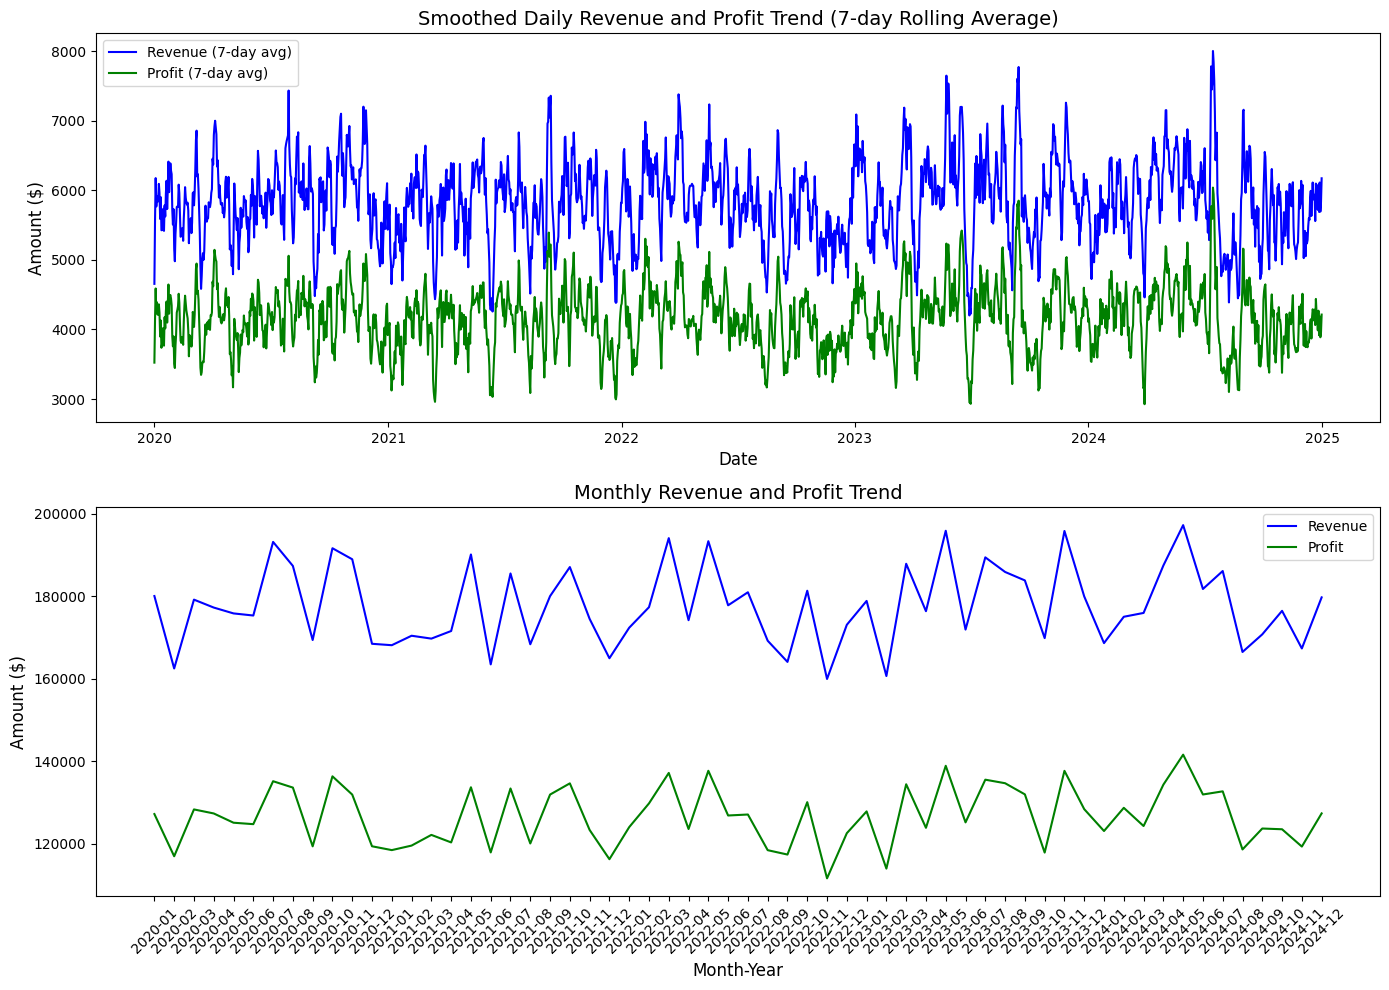

In [7]:
# Aggregate daily sales
daily = df_clean.groupby('date')[['revenue', 'profit']].sum().reset_index()

# Calculate 7-day rolling averages
daily['revenue_rolling'] = daily['revenue'].rolling(window=7, min_periods=1).mean()
daily['profit_rolling'] = daily['profit'].rolling(window=7, min_periods=1).mean()

# Aggregate by month
daily['month_year'] = daily['date'].dt.to_period('M').astype(str)  # Convert to string
monthly = daily.groupby('month_year')[['revenue', 'profit']].sum().reset_index()

# Create one figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=False)

# Plot smoothed daily data on first subplot
sns.lineplot(data=daily, x='date', y='revenue_rolling', label='Revenue (7-day avg)', color='blue', ax=axs[0])
sns.lineplot(data=daily, x='date', y='profit_rolling', label='Profit (7-day avg)', color='green', ax=axs[0])
axs[0].set_title("Smoothed Daily Revenue and Profit Trend (7-day Rolling Average)", fontsize=14)
axs[0].set_xlabel("Date", fontsize=12)
axs[0].set_ylabel("Amount ($)", fontsize=12)
axs[0].legend()

# Plot monthly aggregated data on second subplot
sns.lineplot(data=monthly, x='month_year', y='revenue', label='Revenue', color='blue', ax=axs[1])
sns.lineplot(data=monthly, x='month_year', y='profit', label='Profit', color='green', ax=axs[1])
axs[1].set_title("Monthly Revenue and Profit Trend", fontsize=14)
axs[1].set_xlabel("Month-Year", fontsize=12)
axs[1].set_ylabel("Amount ($)", fontsize=12)
axs[1].tick_params(axis='x', rotation=45)
axs[1].legend()

plt.tight_layout()
plt.show()

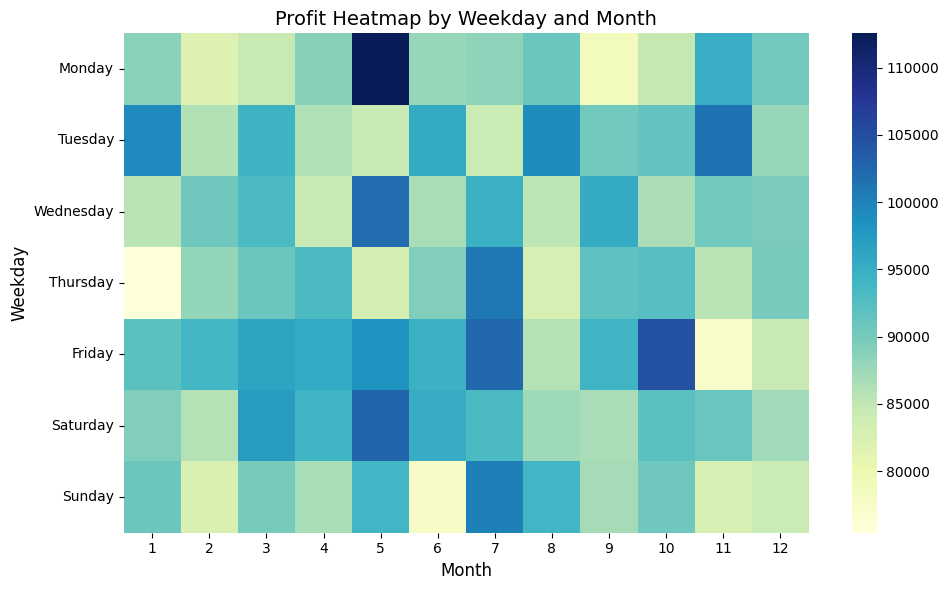

In [8]:
# Define the correct order of weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Ensure 'weekday' is categorical with the specified order
df_clean['weekday'] = pd.Categorical(df_clean['weekday'], categories=weekday_order, ordered=True)

# Group by weekday and month, then create the heatmap
heat = df_clean.groupby(['weekday', 'month'])['profit'].sum().unstack()

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heat, cmap='YlGnBu', annot=False, fmt='.0f')
plt.title("Profit Heatmap by Weekday and Month", fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Weekday', fontsize=12)
plt.tight_layout()
plt.show()

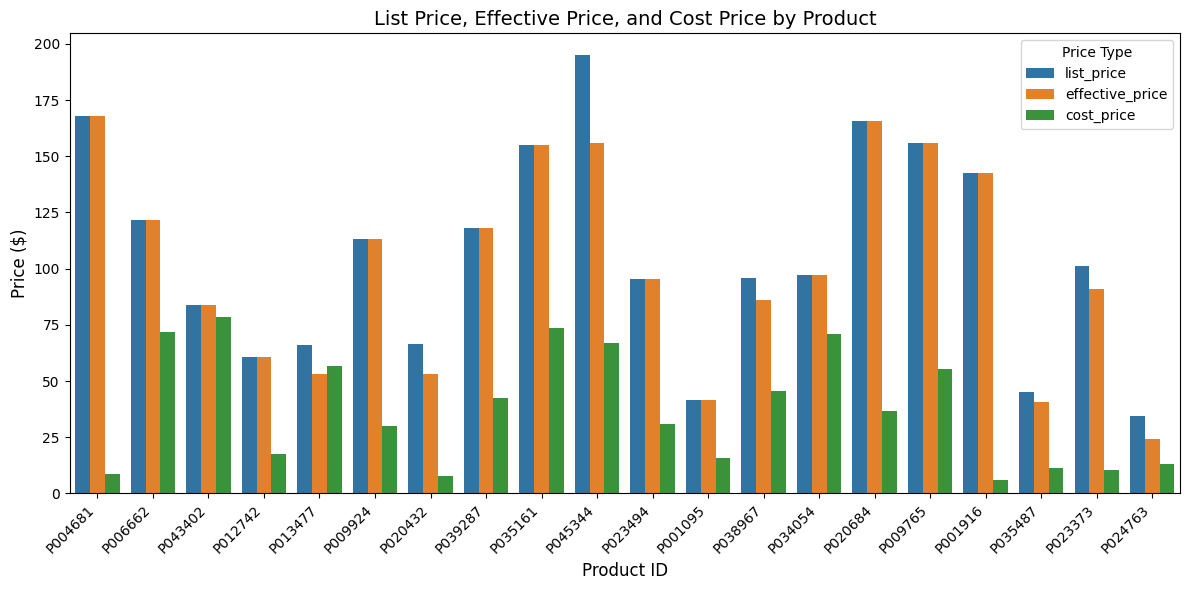

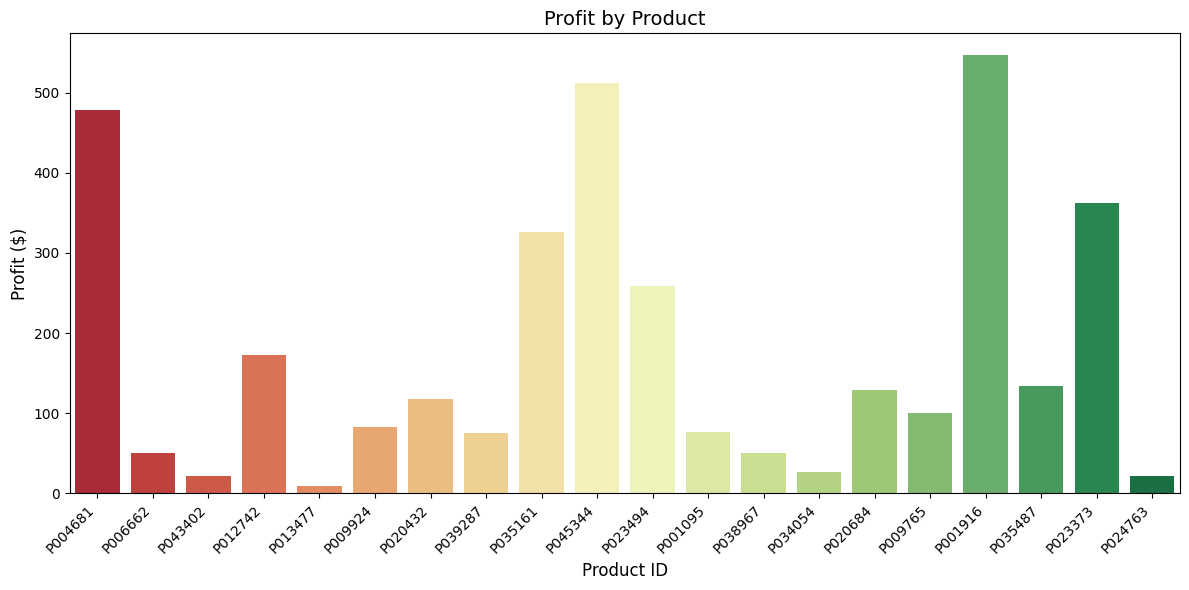

In [9]:
# Calculate effective selling price
df_clean['effective_price'] = df_clean['revenue'] / df_clean['quantity']

# Select a sample of products for clarity (e.g., first 20 unique products)
sample_products = df_clean[['product_id', 'list_price', 'effective_price', 'cost_price', 'profit']].drop_duplicates('product_id').head(20)

# Melt the DataFrame for plotting
melted_df = sample_products.melt(id_vars='product_id', value_vars=['list_price', 'effective_price', 'cost_price'], 
                                 var_name='Price_Type', value_name='Price')

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='product_id', y='Price', hue='Price_Type', data=melted_df)
plt.title('List Price, Effective Price, and Cost Price by Product', fontsize=14)
plt.xlabel('Product ID', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Price Type')
plt.tight_layout()
plt.show()

# Plot profit separately to avoid scale issues
plt.figure(figsize=(12, 6))
sns.barplot(x='product_id', y='profit', data=sample_products, palette='RdYlGn')
plt.title('Profit by Product', fontsize=14)
plt.xlabel('Product ID', fontsize=12)
plt.ylabel('Profit ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

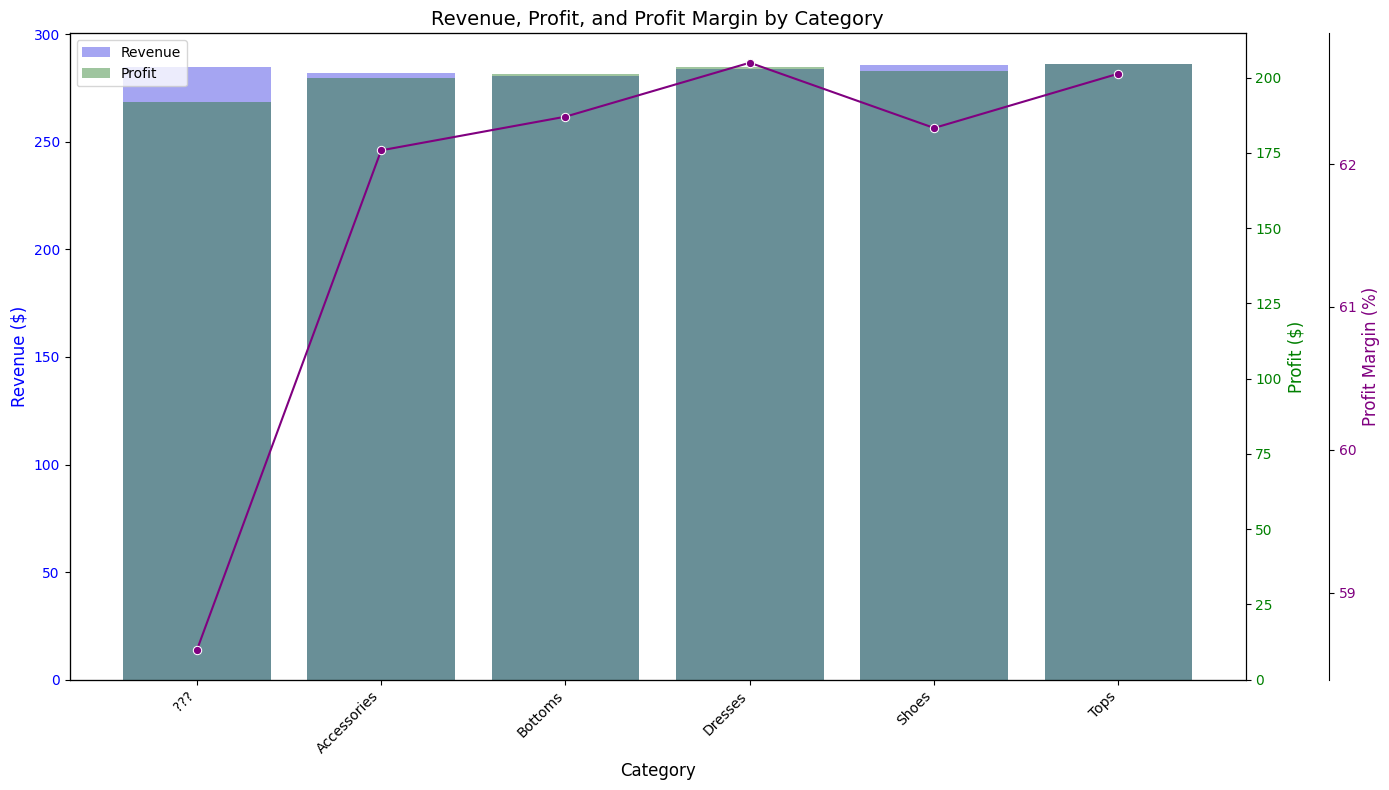

In [10]:
df_clean['profit_margin'] = ((df_clean['list_price'] - df_clean['cost_price']) / df_clean['list_price']) * 100
margin_by_supplier = df_clean.groupby('supplier')['profit_margin'].mean().sort_values()

# Aggregate by category
category_agg = df_clean.groupby('category')[['revenue', 'profit', 'profit_margin']].mean().reset_index()

# Bar plot with dual axes
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot revenue and profit
sns.barplot(data=category_agg, x='category', y='revenue', color='blue', alpha=0.4, label='Revenue', ax=ax1)
ax1.set_ylabel('Revenue ($)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Category', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Secondary axis for profit
ax2 = ax1.twinx()
sns.barplot(data=category_agg, x='category', y='profit', color='green', alpha=0.4, label='Profit', ax=ax2)
ax2.set_ylabel('Profit ($)', color='green', fontsize=12)
ax2.tick_params(axis='y', labelcolor='green')

# Line plot for profit margin
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Offset third axis
sns.lineplot(data=category_agg, x='category', y='profit_margin', color='purple', marker='o', ax=ax3)
ax3.set_ylabel('Profit Margin (%)', color='purple', fontsize=12)
ax3.tick_params(axis='y', labelcolor='purple')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper left')
plt.title('Revenue, Profit, and Profit Margin by Category', fontsize=14)
plt.tight_layout()
plt.show()

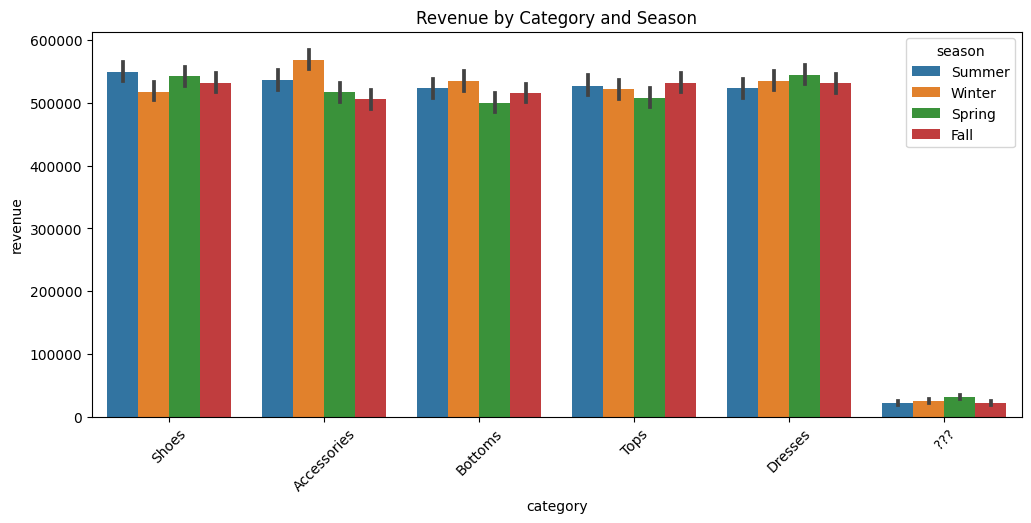

In [11]:
# Revenue by category and season
plt.figure(figsize=(12,5))
sns.barplot(data=df_clean, x='category', y='revenue', hue='season', estimator='sum')
plt.title("Revenue by Category and Season")
plt.xticks(rotation=45)
plt.show()

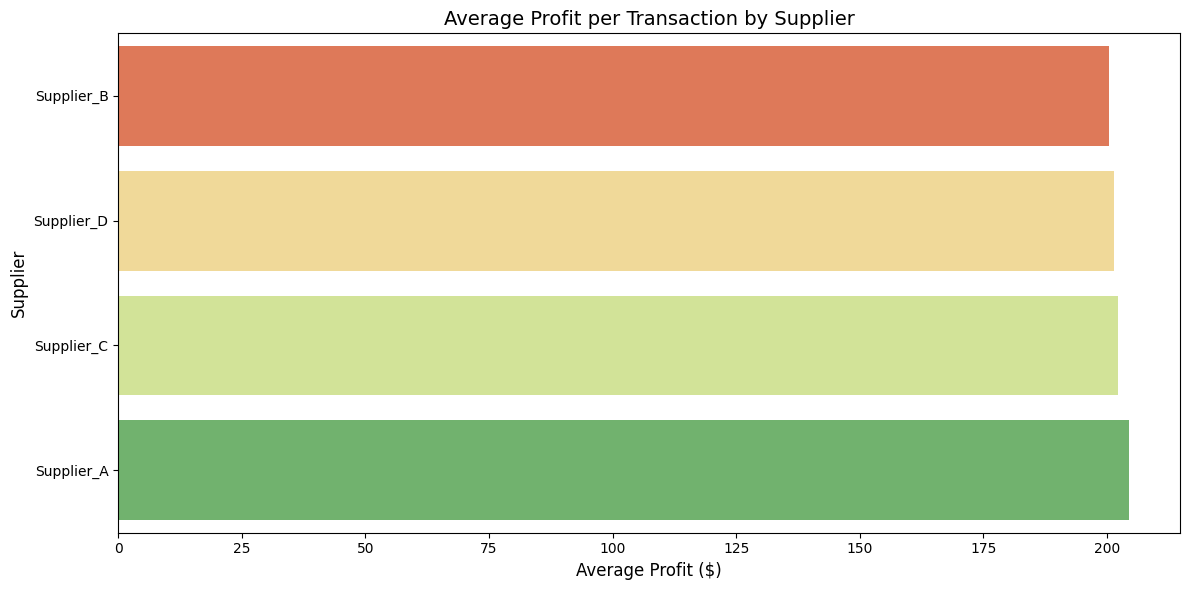

In [12]:
avg_profit_by_supplier = df_clean.groupby('supplier')['profit'].mean().sort_values()
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_profit_by_supplier.values, y=avg_profit_by_supplier.index, palette='RdYlGn')
plt.title('Average Profit per Transaction by Supplier', fontsize=14)
plt.xlabel('Average Profit ($)', fontsize=12)
plt.ylabel('Supplier', fontsize=12)
plt.tight_layout()
plt.show()

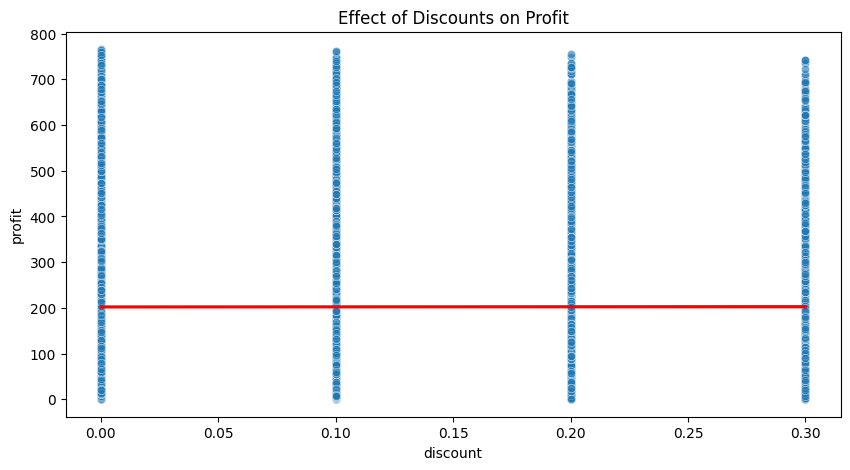

In [13]:
# Discount vs Profit relationship
plt.figure(figsize=(10,5))
sns.scatterplot(data=df_clean, x='discount', y='profit', alpha=0.6)
sns.regplot(data=df_clean, x='discount', y='profit', scatter=False, color='red')
plt.title("Effect of Discounts on Profit")
plt.show()

*Even at higher discounts (e.g., 0.25–0.30), some transactions still yield profits above 200, suggesting that discounts don't always lead to lower profits and may depend on other factors (e.g., quantity sold, product price).*

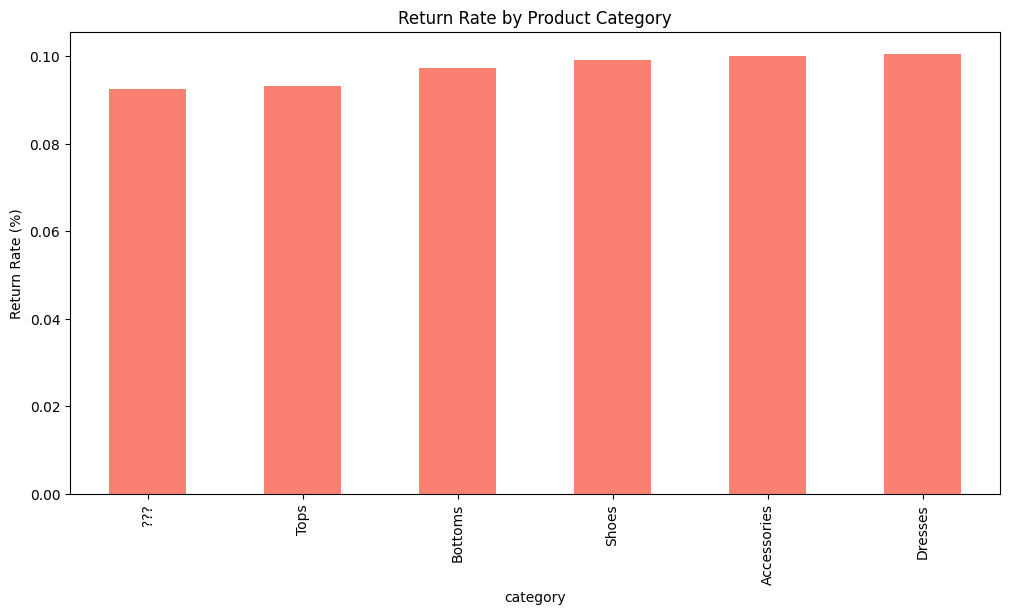

In [14]:
# Return rate by category
returns = df_clean.groupby('category')['returned'].mean().sort_values(ascending=True)
returns.plot(kind='bar', figsize=(12,6), color='salmon')
plt.title("Return Rate by Product Category")
plt.ylabel("Return Rate (%)")
plt.show()

store_size_cat
Small     22496
Medium    14961
NaN         155
Large         0
Name: count, dtype: int64


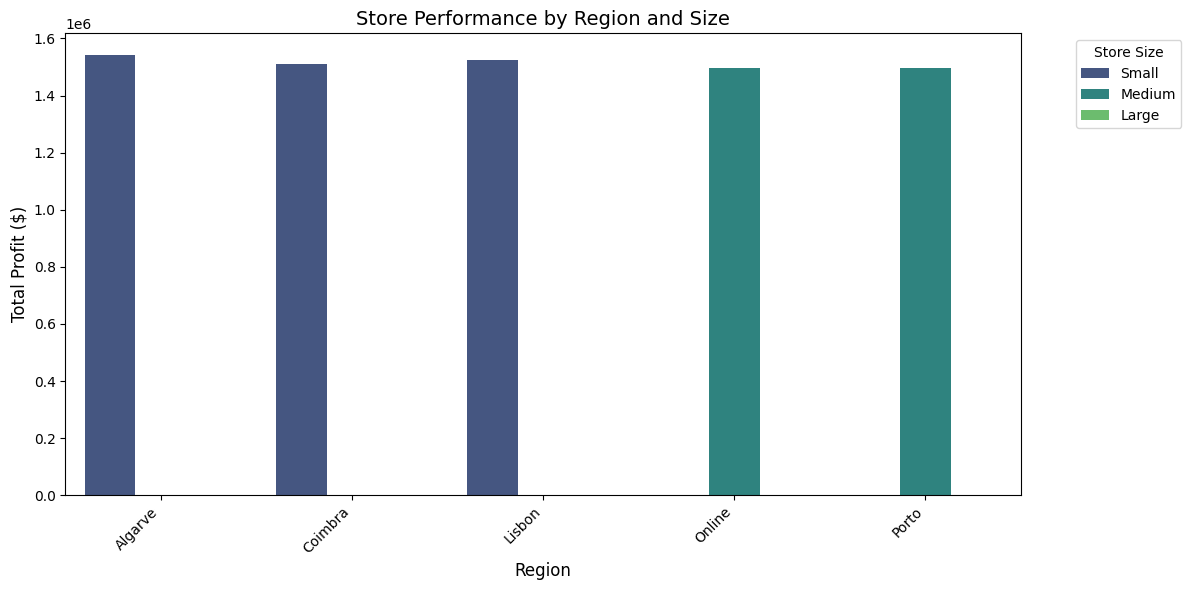

In [15]:
# Bin store sizes into categories
bins = [0, 500, 1000, float('inf')]
labels = ['Small', 'Medium', 'Large']
df_clean['store_size_cat'] = pd.cut(
    df_clean['store_size_m2'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)

# Confirm bins worked
print(df_clean['store_size_cat'].value_counts(dropna=False))

# Aggregate and plot
performance_data = df_clean.groupby(['region', 'store_size_cat'], observed=True)['profit'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='region', y='profit', hue='store_size_cat', data=performance_data, palette='viridis')

plt.title('Store Performance by Region and Size', fontsize=14)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Total Profit ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Store Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


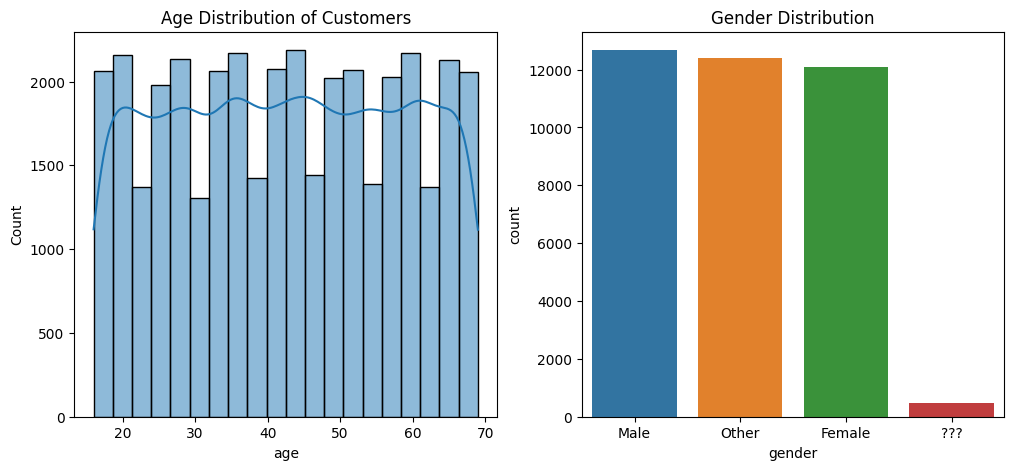

In [16]:
# Customer Demographics
fig, ax = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(df_clean['age'], bins=20, kde=True, ax=ax[0])
sns.countplot(data=df_clean, x='gender', ax=ax[1])
ax[0].set_title("Age Distribution of Customers")
ax[1].set_title("Gender Distribution")
plt.show()

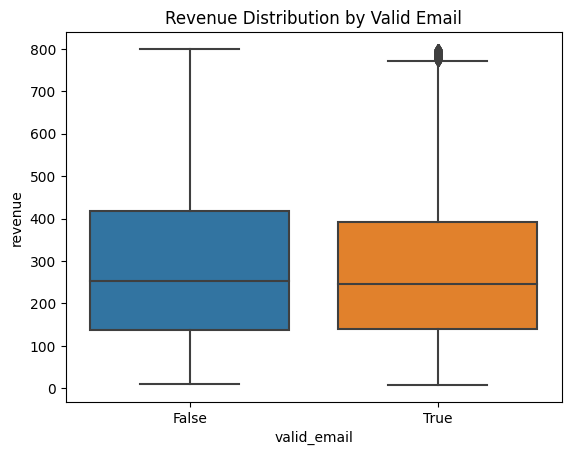

In [17]:
# Email validity vs Revemue
sns.boxplot(data=df_clean, x='valid_email', y='revenue')
plt.title("Revenue Distribution by Valid Email")
plt.show()

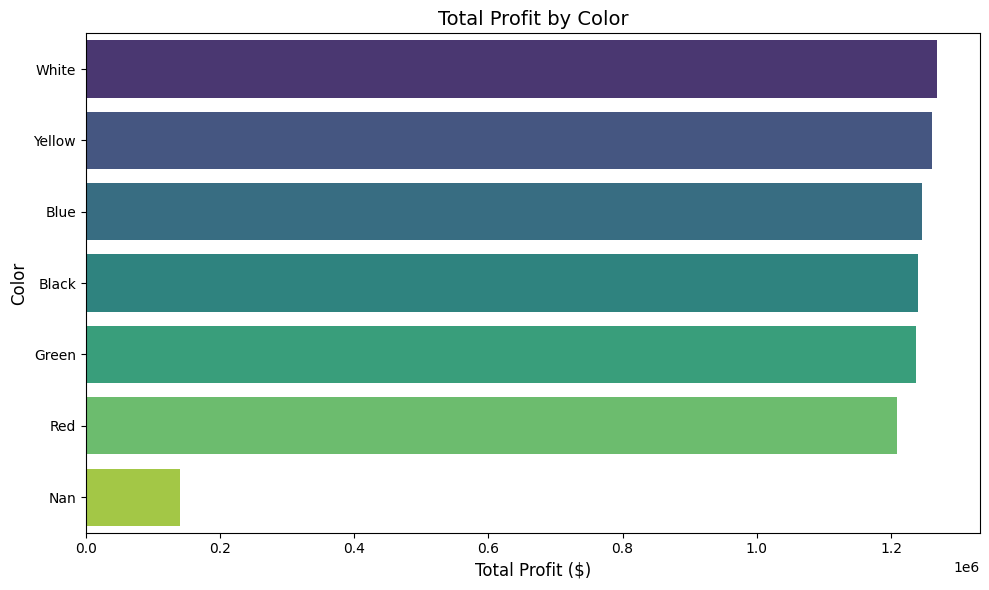

In [18]:
# Group by color and calculate total profit
profit_by_color = df_clean.groupby('color')['profit'].sum().sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=profit_by_color.values, y=profit_by_color.index, palette='viridis')
plt.title('Total Profit by Color', fontsize=14)
plt.xlabel('Total Profit ($)', fontsize=12)
plt.ylabel('Color', fontsize=12)
plt.tight_layout()
plt.show()

# Imputation 📊

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# Separate rows with known and unknown categories
known_data = df_clean[df_clean['category'] != '???']
unknown_data = df_clean[df_clean['category'] == '???']

# Prepare features (price) and target (category)
X_train = known_data[['list_price']]  # Feature: price for training
y_train = known_data['category']  # Target: known categories
X_test = unknown_data[['list_price']]  # Feature: price for rows with '???'

# Scale the price feature (important for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train KNN model
knn = KNeighborsClassifier(n_neighbors=3)  # Adjust n_neighbors as needed
knn.fit(X_train_scaled, y_train)

# Predict missing categories
predicted_categories = knn.predict(X_test_scaled)

# Replace '???' with predicted categories
df_clean.loc[df_clean['category'] == '???', 'category'] = predicted_categories

# Verify the result
print("\nCategory distribution after imputation:")
print(df_clean['category'].value_counts())


Category distribution after imputation:
category
Accessories    7660
Dresses        7566
Shoes          7565
Bottoms        7473
Tops           7348
Name: count, dtype: int64


In [20]:

class ImputationPipeline:
    """
    Handles missing value imputations for retail transaction data,
    and prints diagnostic statistics after imputation.
    """

    def __init__(self):
        """
        Initialize the pipeline. 
        """
        pass

    # ====== IMPUTATION METHODS ======
    def _fill_discount(self, df: pd.DataFrame) -> pd.DataFrame:
        if 'discount' in df.columns:
            nan_count = df['discount'].isna().sum()
            if nan_count > 0:
                print(f"Imputing {nan_count} NaN values in 'discount'")
            df['discount'] = df['discount'].fillna(0.0)
        return df

    def _fill_gender(self, df: pd.DataFrame) -> pd.DataFrame:
        if 'gender' in df.columns:
            nan_count = df['gender'].isna().sum()
            if nan_count > 0:
                print(f"Imputing {nan_count} NaN values in 'gender'")
            df['gender'] = df['gender'].replace('???', 'Unknown').fillna('Unknown')
        return df

    def _fill_color(self, df: pd.DataFrame) -> pd.DataFrame:
        if 'color' in df.columns:
            nan_count = df['color'].isna().sum()
            if nan_count > 0:
                print(f"Imputing {nan_count} NaN values in 'color'")
            df['color'] = df['color'].astype(str).fillna('Unknown').replace('nan', 'Unknown')
            if df['color'].isna().sum() == 0:
                print("All NaN values in 'color' successfully imputed")
            else:
                print(f"Warning: {df['color'].isna().sum()} NaN values remain in 'color'")
        return df

    def _fill_age(self, df: pd.DataFrame) -> pd.DataFrame:
        if 'age' in df.columns:
            nan_count = df['age'].isna().sum()
            if nan_count > 0:
                print(f"Imputing {nan_count} NaN values in 'age'")
            median_age = df['age'].median()
            df['age'] = df['age'].fillna(median_age)
        return df

    def _fill_store_size_m2(self, df: pd.DataFrame) -> pd.DataFrame:
        if 'store_size_m2' in df.columns:
            nan_count = df['store_size_m2'].isna().sum()
            if nan_count > 0:
                print(f"Imputing {nan_count} NaN values in 'store_size_m2'")
            median_size = df['store_size_m2'].median()
            df['store_size_m2'] = df['store_size_m2'].fillna(median_size)
        return df

    def _fill_store_size_cat(self, df: pd.DataFrame) -> pd.DataFrame:
        if 'store_size_cat' in df.columns:
            nan_count = df['store_size_cat'].isna().sum()
            if nan_count > 0:
                print(f"Imputing {nan_count} NaN values in 'store_size_cat'")
            mode_size = df['store_size_cat'].mode()[0] if not df['store_size_cat'].mode().empty else 'Unknown'
            df['store_size_cat'] = df['store_size_cat'].fillna(mode_size)
        return df

    def _fill_identifiers(self, df: pd.DataFrame) -> pd.DataFrame:
        for col in ['customer_id', 'email']:
            if col in df.columns:
                nan_count = df[col].isna().sum()
                if nan_count > 0:
                    print(f"Imputing {nan_count} NaN values in '{col}'")
                df[col] = df[col].fillna('Unknown')
        return df

    # ====== STATISTICS METHOD ======
    def _print_statistics(self, df: pd.DataFrame):
        """
        Print diagnostic statistics after imputation.
        """
        print("\n=== Post-Imputation Statistics ===")

        # Numerical columns
        num_cols = ['age', 'discount', 'store_size_m2']
        for col in num_cols:
            if col in df.columns:
                print(f"\nSummary statistics for '{col}':")
                print(df[col].describe())

        # Categorical columns
        cat_cols = ['gender', 'color', 'store_size_cat']
        for col in cat_cols:
            if col in df.columns:
                print(f"\nValue counts for '{col}':")
                print(df[col].value_counts(dropna=False))

        # Profit by color
        if 'color' in df.columns and 'profit' in df.columns:
            print("\nTotal profit by color (sorted by profit):")
            profit_by_color = df.groupby('color')['profit'].sum().sort_values(ascending=False)
            print(profit_by_color)
            print("\nAverage profit by color (sorted by profit):")
            avg_profit_by_color = df.groupby('color')['profit'].mean().sort_values(ascending=False)
            print(avg_profit_by_color)

    # ====== PIPELINE METHODS ======
    def fit(self, df: pd.DataFrame) -> pd.DataFrame:
        return self

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        # Print initial NaN counts
        print("Initial NaN counts:")
        for col in ['discount', 'gender', 'color', 'age', 'store_size_m2', 'store_size_cat', 'customer_id', 'email']:
            if col in df.columns:
                print(f"  {col}: {df[col].isna().sum()}")

        # Apply imputations
        df = self._fill_discount(df)
        df = self._fill_gender(df)
        df = self._fill_color(df)
        df = self._fill_age(df)
        df = self._fill_store_size_m2(df)
        df = self._fill_store_size_cat(df)
        df = self._fill_identifiers(df)

        # Print final NaN counts
        print("\nFinal NaN counts after imputation:")
        for col in ['discount', 'gender', 'color', 'age', 'store_size_m2', 'store_size_cat', 'customer_id', 'email']:
            if col in df.columns:
                print(f"  {col}: {df[col].isna().sum()}")

        # Print statistics
        self._print_statistics(df)

        return df

    def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        return self.fit(df).transform(df)

In [21]:
pipeline = ImputationPipeline()
df_clean = pipeline.fit_transform(df_clean)

Initial NaN counts:
  discount: 0
  gender: 0
  color: 0
  age: 0
  store_size_m2: 155
  store_size_cat: 155
  customer_id: 0
  email: 785
All NaN values in 'color' successfully imputed
Imputing 155 NaN values in 'store_size_m2'
Imputing 155 NaN values in 'store_size_cat'
Imputing 785 NaN values in 'email'

Final NaN counts after imputation:
  discount: 0
  gender: 0
  color: 0
  age: 0
  store_size_m2: 0
  store_size_cat: 0
  customer_id: 0
  email: 0

=== Post-Imputation Statistics ===

Summary statistics for 'age':
count    37612.000000
mean        42.545890
std         15.572355
min         16.000000
25%         29.000000
50%         43.000000
75%         56.000000
max         69.000000
Name: age, dtype: float64

Summary statistics for 'discount':
count    37612.000000
mean         0.058287
std          0.088267
min          0.000000
25%          0.000000
50%          0.000000
75%          0.100000
max          0.300000
Name: discount, dtype: float64

Summary statistics for 'store_

# Prophet🔮
## *Predict profit (for next 24 mnths)*

11:14:23 - cmdstanpy - INFO - Chain [1] start processing
11:14:24 - cmdstanpy - INFO - Chain [1] done processing
11:14:24 - cmdstanpy - INFO - Chain [1] start processing
11:14:24 - cmdstanpy - INFO - Chain [1] done processing
11:14:24 - cmdstanpy - INFO - Chain [1] start processing
11:14:25 - cmdstanpy - INFO - Chain [1] done processing
11:14:25 - cmdstanpy - INFO - Chain [1] start processing
11:14:27 - cmdstanpy - INFO - Chain [1] done processing
11:14:27 - cmdstanpy - INFO - Chain [1] start processing
11:14:28 - cmdstanpy - INFO - Chain [1] done processing
11:14:28 - cmdstanpy - INFO - Chain [1] start processing
11:14:28 - cmdstanpy - INFO - Chain [1] done processing


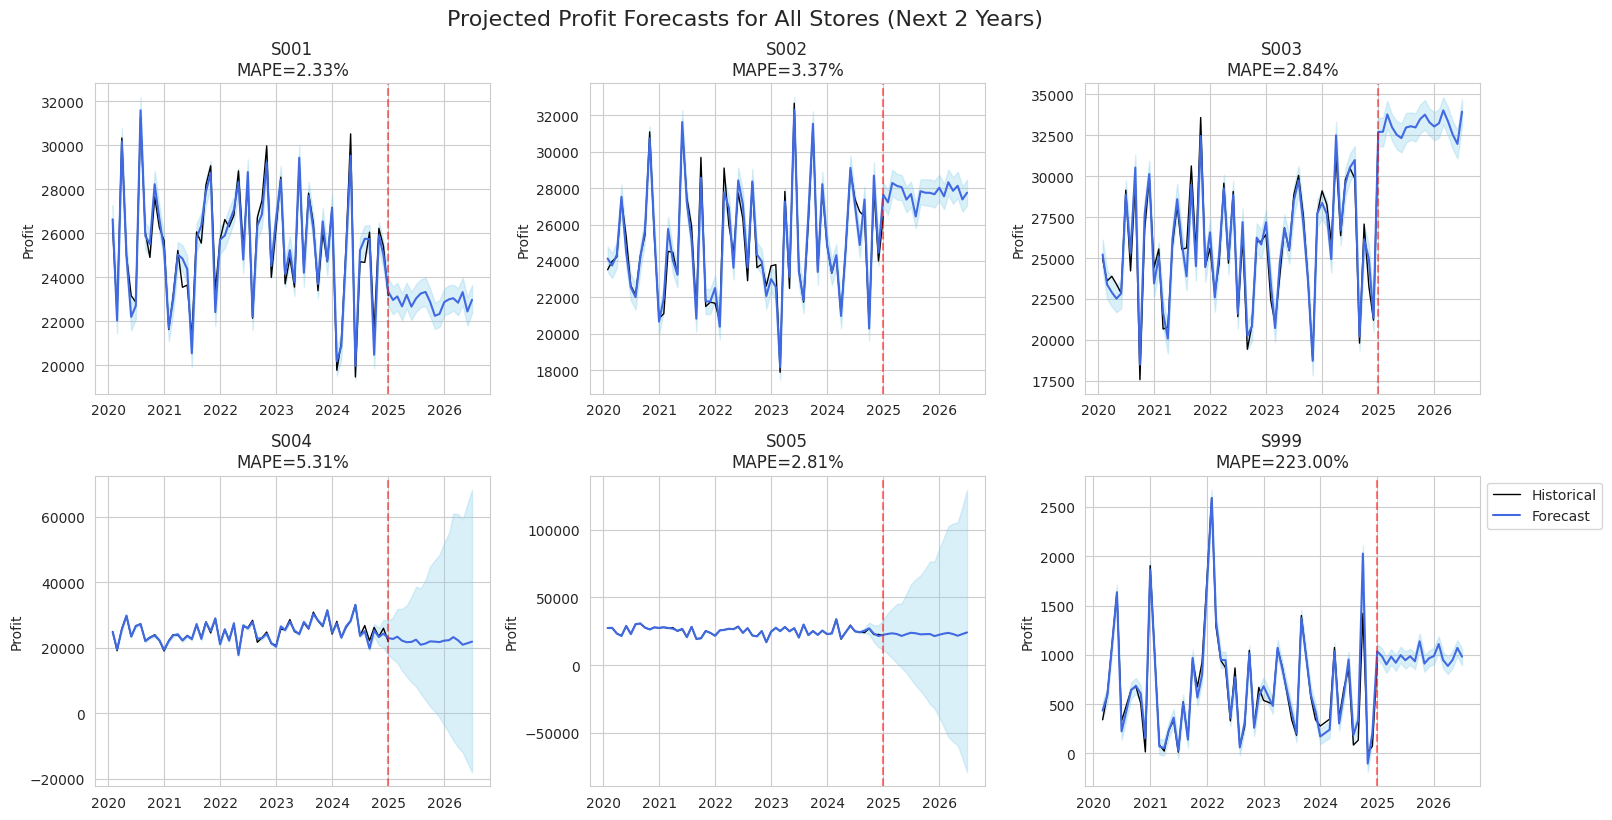

In [22]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error


# ============================================================
# PREPARE DATA
# ============================================================

df = df_clean.copy()
df['date'] = pd.to_datetime(df['date'])

# Aggregate profit monthly per store
store_monthly = (
    df.groupby(['store_id', pd.Grouper(key='date', freq='M')])
      .agg({
          'profit': 'sum',
          'discount': 'mean',
          'store_size_m2': 'mean',
          'revenue': 'sum'
      })
      .reset_index()
      .rename(columns={'date': 'ds', 'profit': 'y'})
)

# Fill missing store_size_m2 with median (contextual)
store_monthly['store_size_m2'] = store_monthly['store_size_m2'].fillna(
    store_monthly.groupby('store_id')['store_size_m2'].transform('median')
)

# ============================================================
# MODEL CONFIGURATION
# ============================================================

def fit_prophet_with_regressors(df_store):
    """Train Prophet model with regressors and return forecast + metrics"""
    # Require minimum history
    if len(df_store) < 24:
        return None, None, None

    # Train-test split (last 6 months for validation)
    df_store = df_store.sort_values('ds')
    train = df_store.iloc[:-6]
    test = df_store.iloc[-6:]

    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode='multiplicative'
    )

    # Add regressors
    for reg in ['discount', 'store_size_m2', 'revenue']:
        model.add_regressor(reg)

    model.fit(train[['ds', 'y', 'discount', 'store_size_m2', 'revenue']])

    # Future dataframe (next 24 months)
    future = model.make_future_dataframe(periods=24, freq='M')
    future = future.merge(df_store[['ds', 'discount', 'store_size_m2', 'revenue']],
                          on='ds', how='left')

    # Forward fill regressors for forecast horizon
    for reg in ['discount', 'store_size_m2', 'revenue']:
        future[reg] = future[reg].fillna(method='ffill')

    forecast = model.predict(future)

    # Validation forecast
    val_forecast = forecast[forecast['ds'].isin(test['ds'])]
    mape = mean_absolute_percentage_error(test['y'], val_forecast['yhat'])

    return model, forecast, mape


# ============================================================
# LOOP THROUGH ALL STORES
# ============================================================

all_forecasts = []
store_metrics = []

for store in store_monthly['store_id'].unique():
    df_store = store_monthly[store_monthly['store_id'] == store]
    model, forecast, mape = fit_prophet_with_regressors(df_store)

    if forecast is None:
        continue

    forecast['store_id'] = store
    forecast['MAPE'] = mape
    all_forecasts.append(forecast)
    store_metrics.append({'store_id': store, 'MAPE': mape})

forecast_all = pd.concat(all_forecasts, ignore_index=True)
metrics_df = pd.DataFrame(store_metrics).sort_values('MAPE')

# ============================================================
# ADD METADATA
# ============================================================

max_date = store_monthly['ds'].max()
forecast_all['is_forecast'] = forecast_all['ds'] > max_date

# ============================================================
# VISUALIZE ALL STORES
# ============================================================

sns.set_style("whitegrid")

unique_stores = forecast_all['store_id'].unique()
n_stores = len(unique_stores)
cols = 3
rows = int(np.ceil(n_stores / cols))

plt.figure(figsize=(5 * cols, 4 * rows))

for i, store in enumerate(unique_stores, 1):
    plt.subplot(rows, cols, i)

    hist = store_monthly[store_monthly['store_id'] == store]
    fcst = forecast_all[forecast_all['store_id'] == store]

    plt.plot(hist['ds'], hist['y'], label='Historical', color='black', linewidth=1)
    plt.plot(fcst['ds'], fcst['yhat'], label='Forecast', color='royalblue', linewidth=1.5)
    plt.fill_between(fcst['ds'], fcst['yhat_lower'], fcst['yhat_upper'], color='skyblue', alpha=0.3)
    plt.axvline(max_date, color='red', linestyle='--', alpha=0.5)
    plt.title(f"{store}\nMAPE={metrics_df.loc[metrics_df['store_id']==store,'MAPE'].values[0]:.2%}")
    plt.xlabel("")
    plt.ylabel("Profit")

plt.tight_layout()
plt.suptitle("Projected Profit Forecasts for All Stores (Next 2 Years)", fontsize=16, y=1.02)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()
